In [13]:
import shap
import copy
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import geopandas

# choose which model to pick
modelpick = 2

In [14]:
params_autobalance_2_classes = {
    "leaf_estimation_method": "Gradient",
    "random_state": 42,
    "verbose": 5,
    "eval_metric": "F1",
    "auto_class_weights": "Balanced",
}

if modelpick == 2:
    X_test = pd.read_pickle("data/X_test_2.pkl")
    X_train = pd.read_pickle("data/X_train_2.pkl")
    y_test = pd.read_pickle("data/y_test_2.pkl")
    y_train = pd.read_pickle("data/y_train_2.pkl")

    with open("./data/cat_features.pkl", "rb") as f:
        cat_features = pickle.load(f)

    X = pd.concat([X_test, X_train])
    Y = pd.concat([y_test, y_train])
    # pd.merge(X_train, y_train, left_index=True, right_index=True)

    dataset = Pool(data=X, label=Y, cat_features=cat_features)
    model = CatBoostClassifier(**params_autobalance_2_classes)
    model.load_model("./models/catboost_2_classes_autobalance")

elif modelpick == 3:
    X_test = pd.read_pickle("data/X_test_3.pkl")
    X_train = pd.read_pickle("data/X_train_3.pkl")
    y_test = pd.read_pickle("data/y_test_3.pkl")
    y_train = pd.read_pickle("data/y_train_3.pkl")

    with open("./data/cat_features_features_influenceable.pkl", "rb") as f:
        cat_features_influenceable = pickle.load(f)

    X = pd.concat([X_test, X_train])
    Y = pd.concat([y_test, y_train])
    # pd.merge(X_train, y_train, left_index=True, right_index=True)

    dataset = Pool(data=X, label=Y, cat_features=cat_features_influenceable)
    model = CatBoostClassifier(**params_autobalance_2_classes)
    model.load_model("./models/catboost_2_classes_autobalance_influenceable_features")

Calculate the shap values with both explainer. via the treeexplainer and the normal one

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X,y=Y)

In [16]:
# get shap values
explainer_E = shap.Explainer(model)
shap_values_E = explainer_E(X,y=Y)

In [41]:
with open('./data/shap_values.pkl', 'wb') as b:
    pickle.dump(shap_values,b)

In [42]:
with open('./data/explainer.pkl', 'wb') as b:
    pickle.dump(explainer,b)

In [17]:
with open('./data/shap_values_E.pkl', 'wb') as b:
    pickle.dump(shap_values_E,b)

In [18]:
class_names =model.classes_
print('0 Slight class: ',class_names[0])
print('1 Serious or Fatal class: ',class_names[1])

0 Slight class:  0
1 Serious or Fatal class:  1


See the overall feature importance

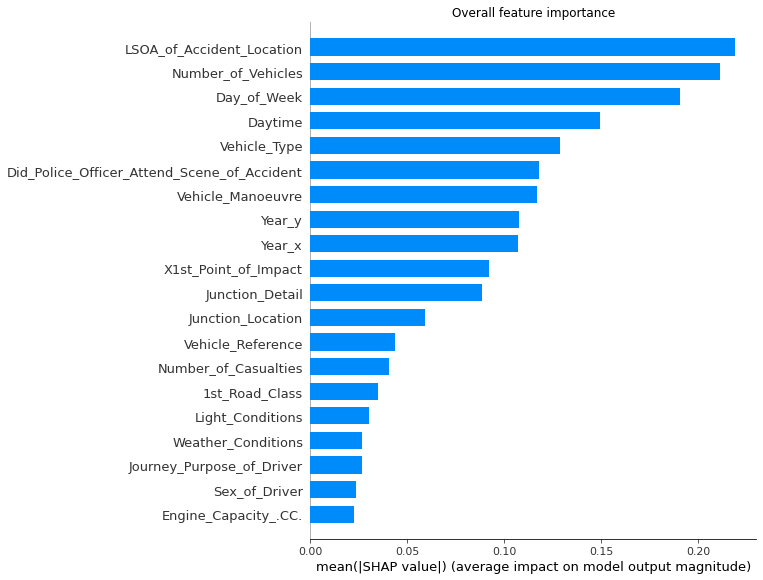

In [40]:
shap.summary_plot(shap_values, X, plot_type="bar", class_names= class_names, feature_names = X.columns,show=False)
plt.title('Overall feature importance')
plt.savefig("./plots/feature_importance.jpg",bbox_inches="tight")
plt.show()

Visaulize the extrem predictions 

In [20]:
shap_values_per_row = shap_values.sum(axis = 1)
index_min = np.argmin(shap_values_per_row)
index_max = np.argmax(shap_values_per_row)
specific_accident = index_max

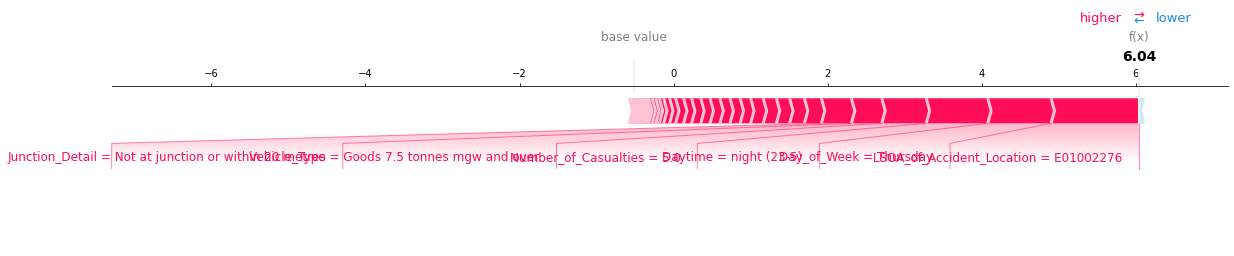

In [45]:
# load JS visualization code to notebook
shap.initjs()
# visualize the first prediction’s explanation
shap.force_plot(explainer.expected_value, shap_values[specific_accident,:], X.iloc[specific_accident,:],matplotlib=True)

In [22]:
print("Class: ", Y.iloc[specific_accident,:].Accident_Severity )
print("Prediction: ",model.predict(X.iloc[specific_accident,:]))

Class:  1
Prediction:  1


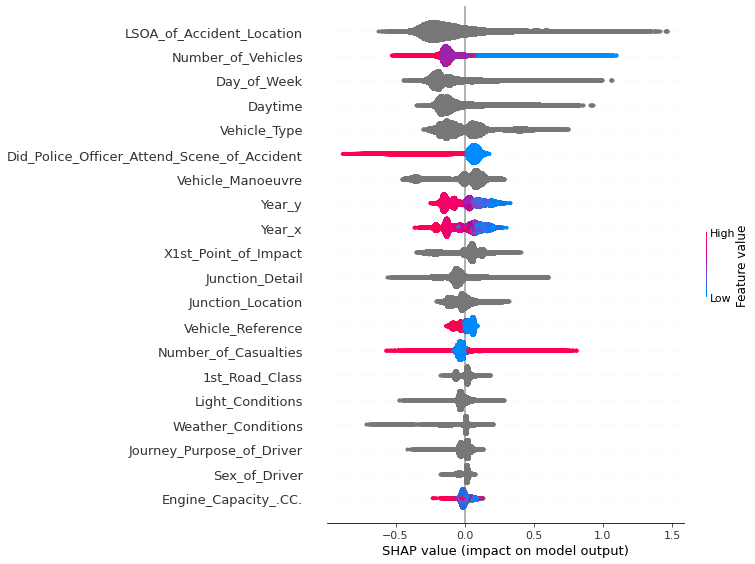

In [23]:
shap.summary_plot(shap_values, X)

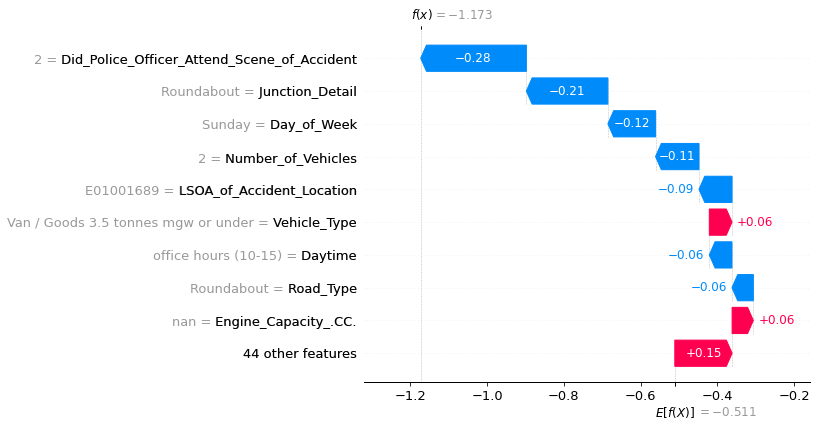

In [24]:
shap.plots.waterfall(shap_values_E[0])

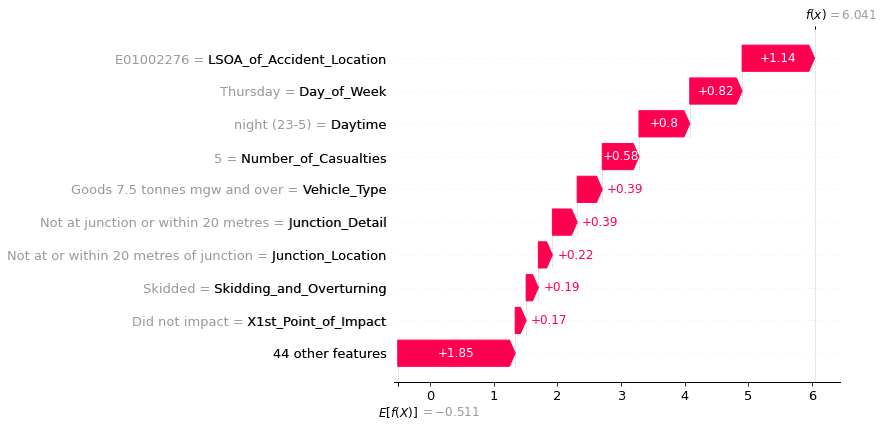

In [25]:
shap.plots.waterfall(shap_values_E[specific_accident])

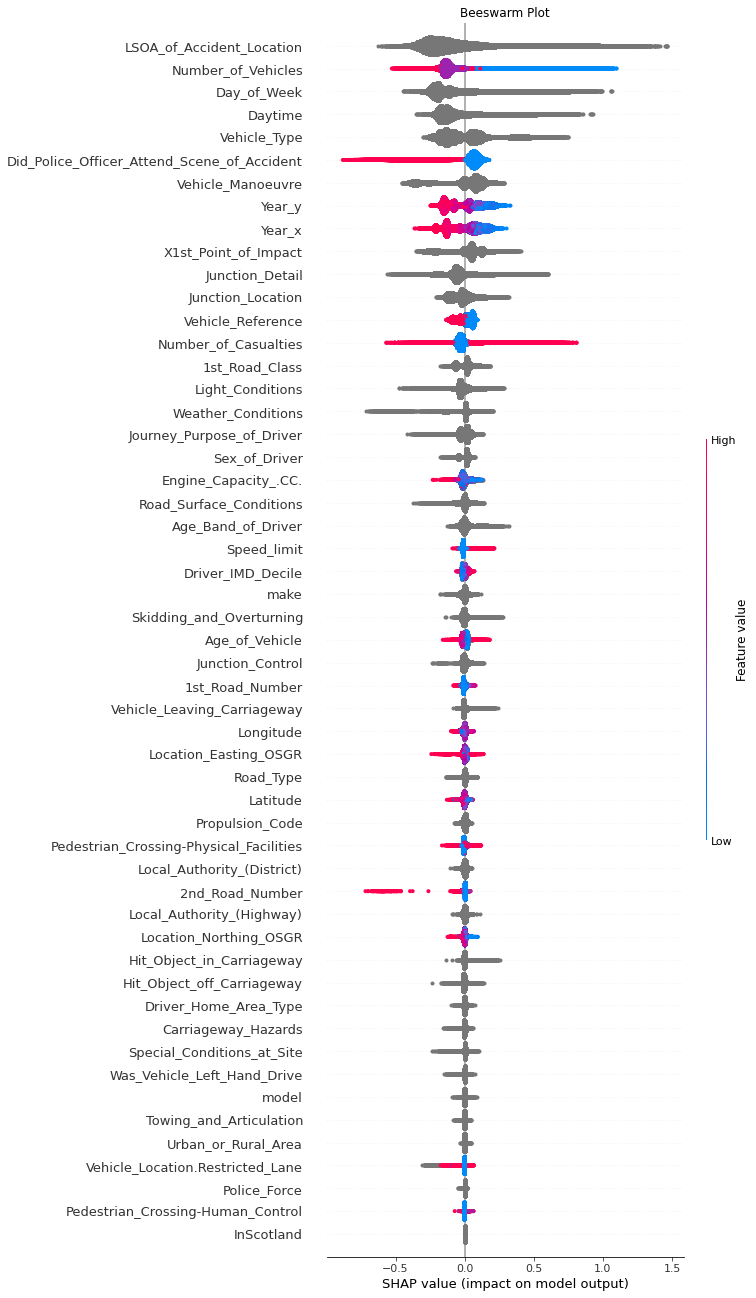

In [38]:
shap.plots.beeswarm(shap_values_E,max_display=60,show=False)
plt.title('Beeswarm Plot')
plt.savefig("./plots/beeswarm.jpg",bbox_inches="tight")
plt.show()

# Plotting for categorical values
this method transformes the shap values for one category
it is then used for plotting beeswarm plots. Thereby the categorical distribution gets visible, which is not visible in the standard plot

In [27]:
# this method transformes the shap values for one category
# it is then used for plotting beeswarm plots. Thereby the categorical distribution gets visible, which is not visible in the standard plot
def transform_shap_values_for_category(shap_values,data,categorical_column):
    #Get shaply values and feature values
    category_values = np.array(shap_values[:,categorical_column].values) 
    category_data = data[categorical_column]
    #Create new SHAP values array
    #Split categorical_column SHAP values by unique categories
    unique_categorical_values = data[categorical_column].unique()
    new_shap_values = [np.array(category_values[category_data==cat])for cat in unique_categorical_values]
    new_shap_values_raw = new_shap_values

    #Each sublist needs to be the same length
    max_len = max([len(v) for v in new_shap_values])
    new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in new_shap_values]
    new_shap_values = np.array(new_shap_values)
    #transpost matrix so categories are columns and SHAP values are rows
    new_shap_values = new_shap_values.transpose()
    #replace shap values
    shap_values.values = np.array(new_shap_values)

    #replace data with placeholder array
    shap_values.data = np.array([[0]*len(unique_categorical_values)]*max_len)

    #replace base data with placeholder array
    shap_values.base = np.array([0]*max_len)
    labels = ["{} ({})".format(u,u) for u in unique_categorical_values]
    shap_values.feature_names = list(labels)
    return shap_values,new_shap_values_raw,unique_categorical_values


In [28]:
feature_columns = ['Number_of_Vehicles','Day_of_Week','Daytime','Vehicle_Type','Did_Police_Officer_Attend_Scene_of_Accident','Vehicle_Manoeuvre','Light_Conditions','Weather_Conditions']

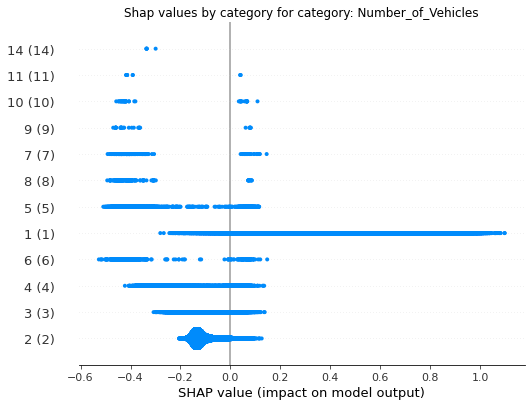

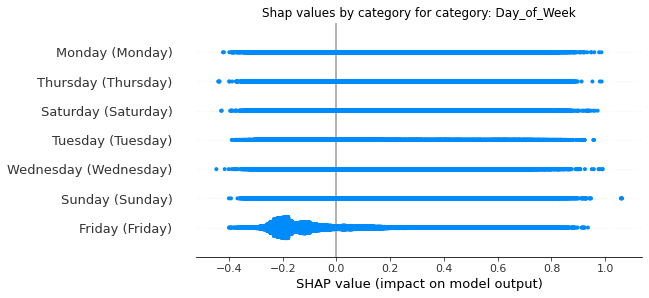

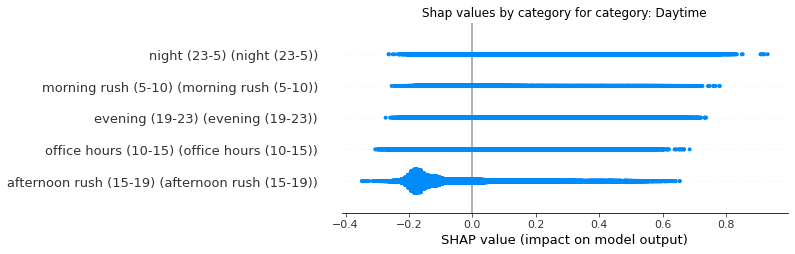

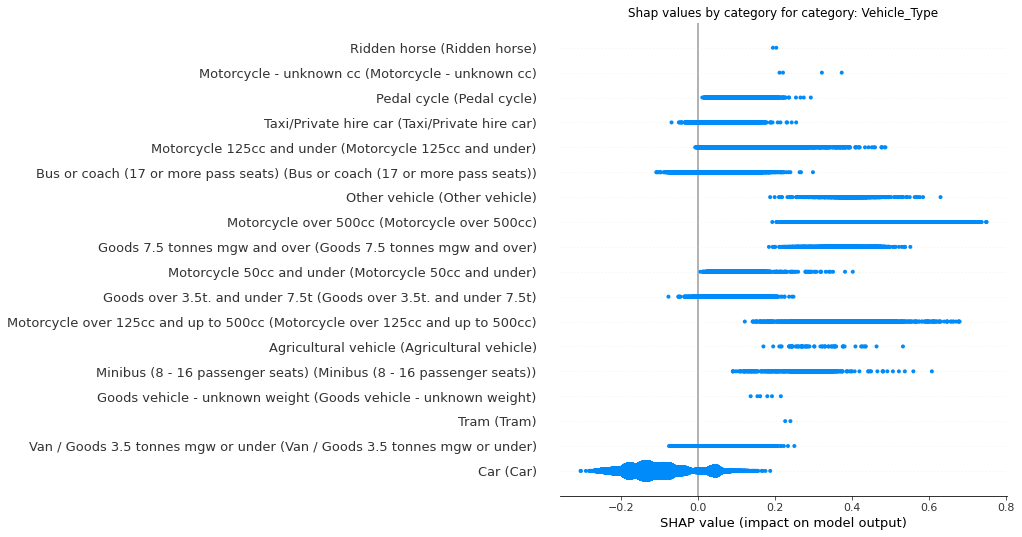

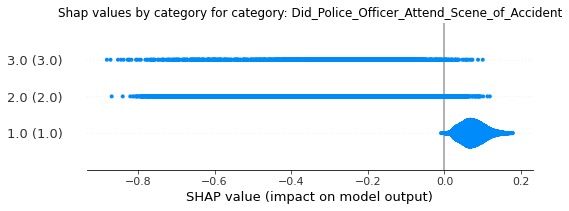

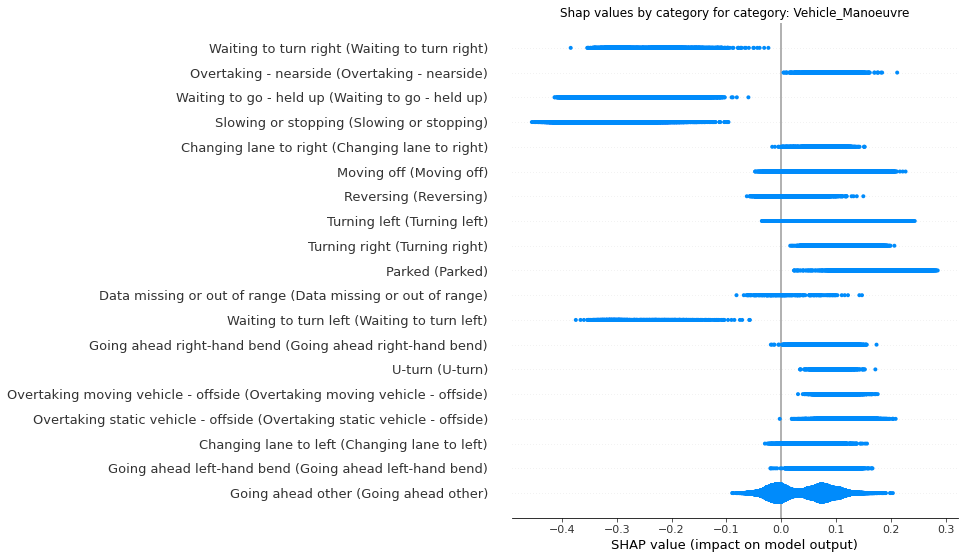

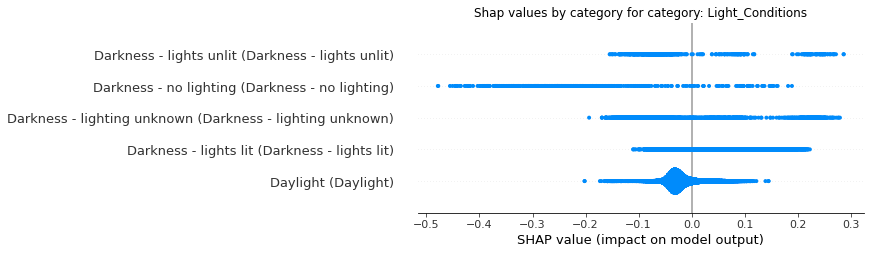

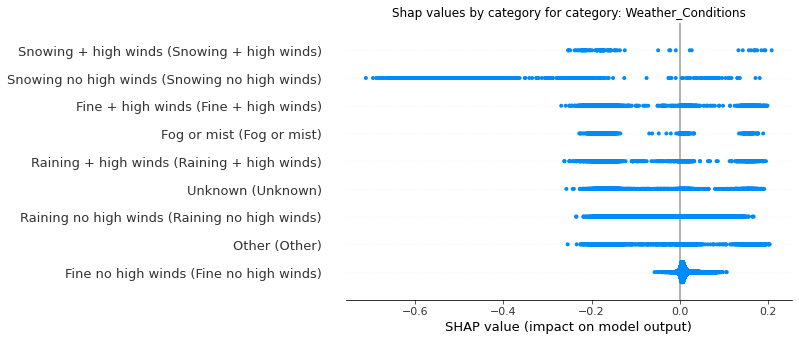

In [29]:
for feature in feature_columns:
    shap_values_category = copy.deepcopy(shap_values_E)
    shap_values_category , new_shap_values_category_raw, unique_categorical_values= transform_shap_values_for_category(shap_values_category,X,feature)
    shap.plots.beeswarm(shap_values_category,color_bar=False,max_display=30,show=False)
    plt.title('Shap values by category for category: '+feature)
    plt.savefig("./plots/categorical_plot_"+feature+".jpg",bbox_inches="tight")
    plt.show()

# Density Plot
A problem with the standard shap beeswarm plot is, that i uses common_norm over all categorical values. If one category outnumbers the others, only the distribution of the majority category is visible.
All other categories are only visible as a line, even if that is not the case.
That is why i decided to plot a density diagram without a common norm. Thereby the distribution for each category gets visible.

In [30]:
# method creates a sub dataframe consistion of a feature column and their shap values
# based on this dataframe density plots can be easly created for the categorical distribution
def create_category_shap_value_dataframe(feature_column):
    df_category_values = pd.Series(shap_values_E[:,feature_column].values)
    category_data = X[feature_column]
    category_data.reset_index(drop=True, inplace=True)
    dist_data = pd.DataFrame(dict(feature_column = category_data, values = df_category_values))
    dist_data.columns=[feature_column,'values']
    return dist_data

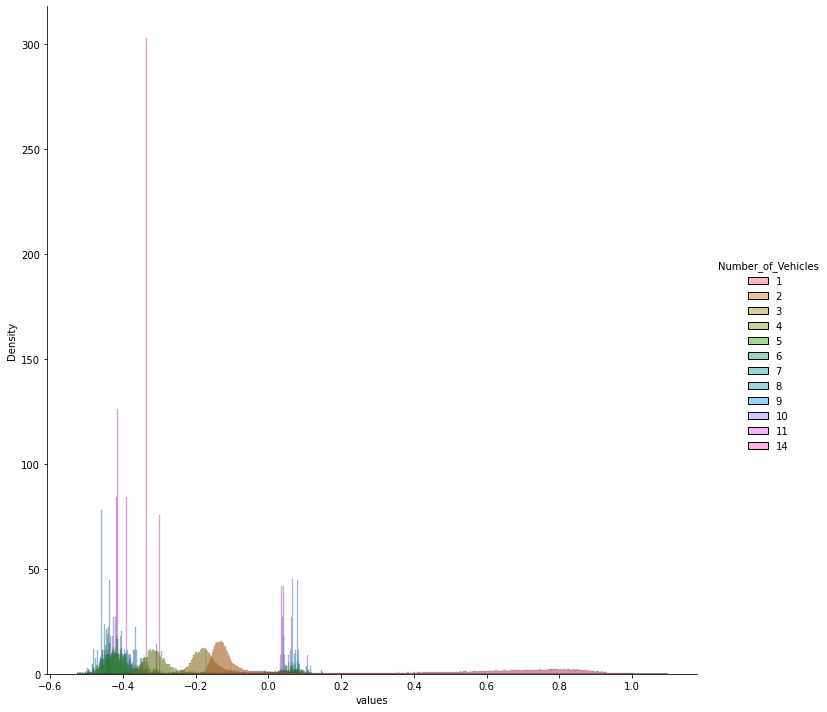

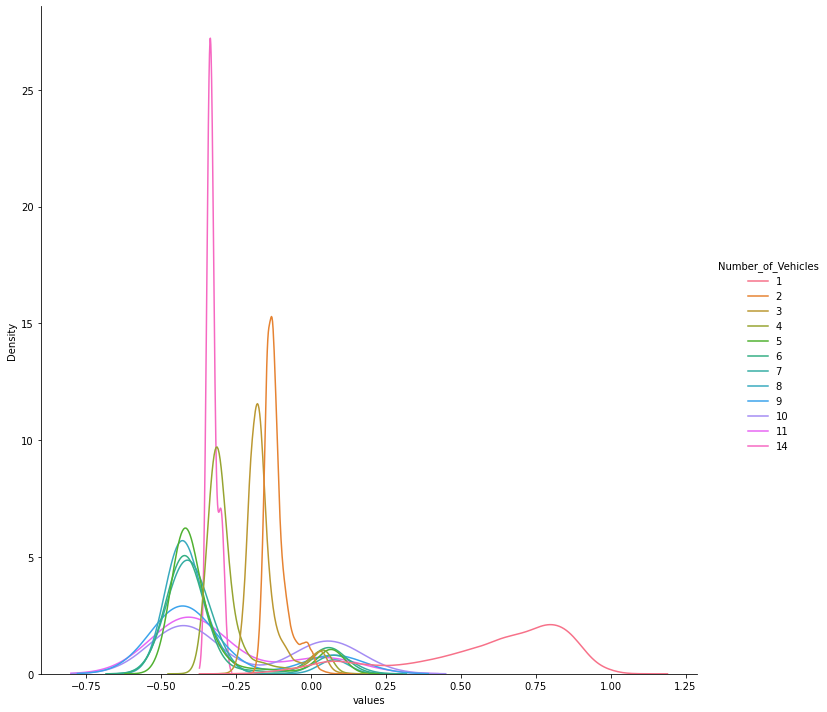

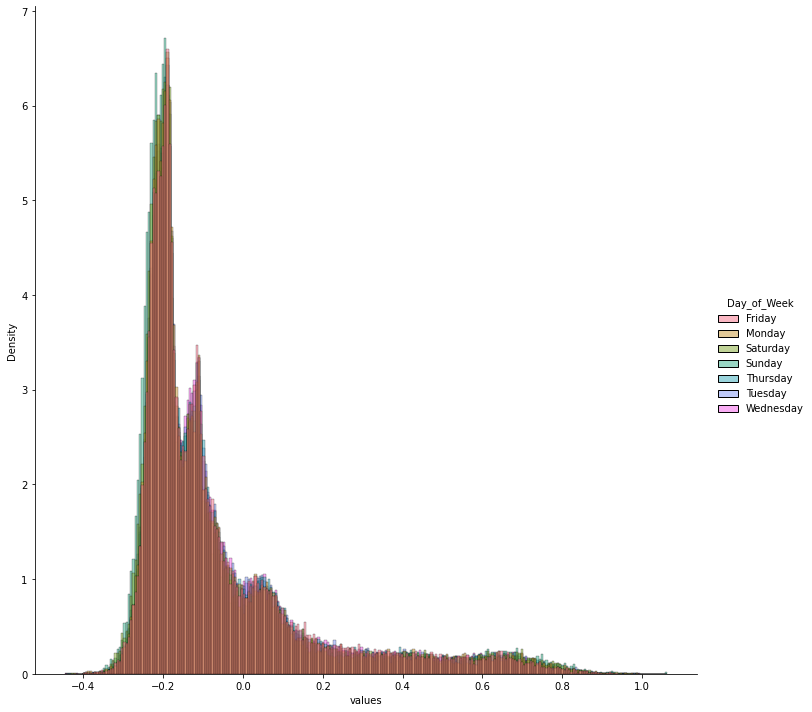

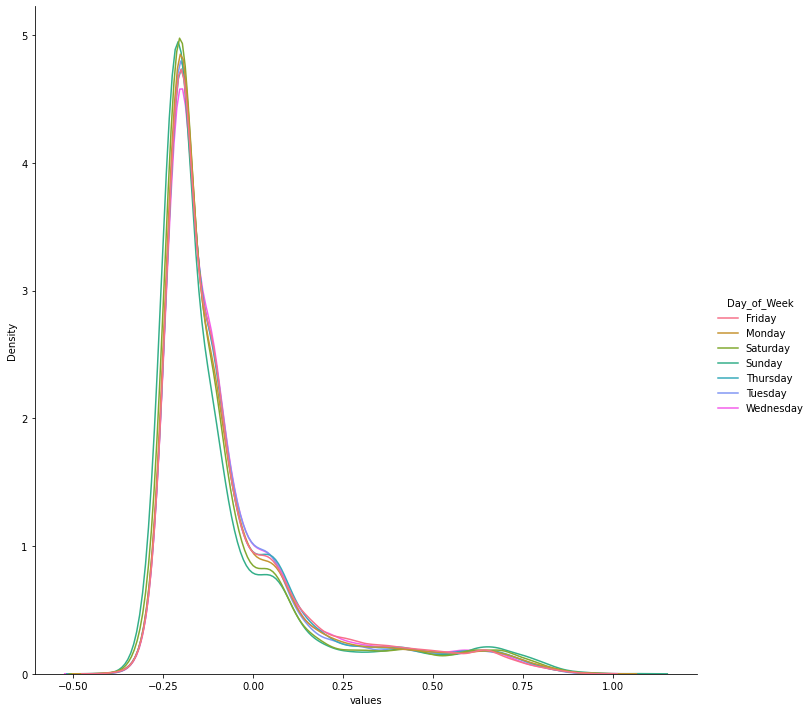

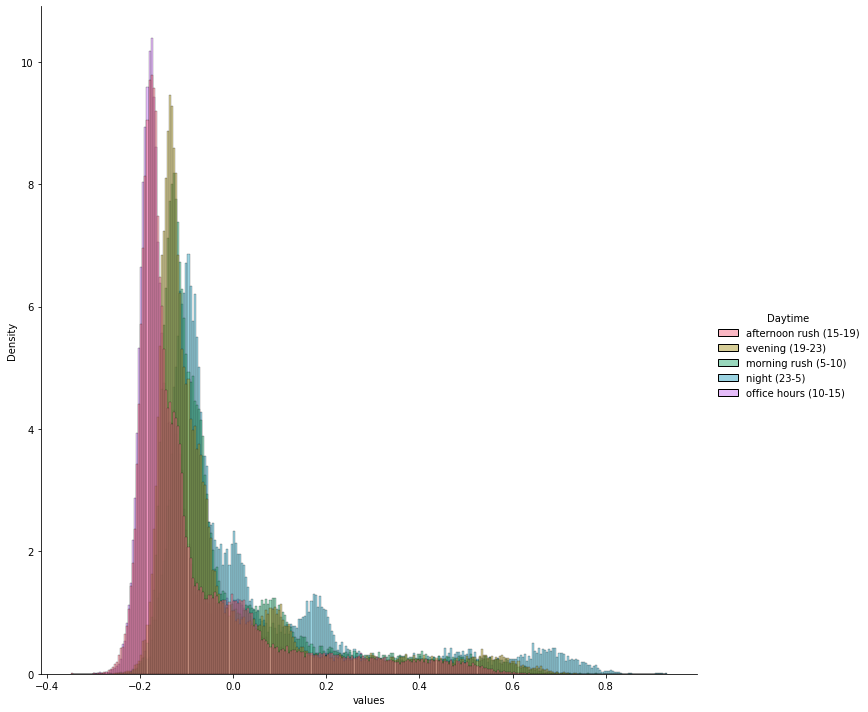

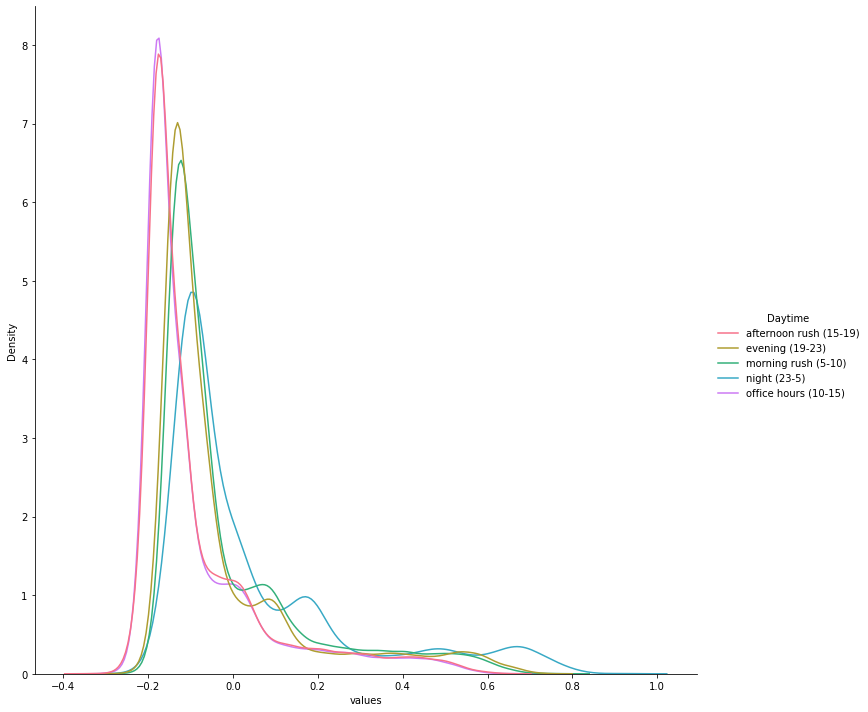

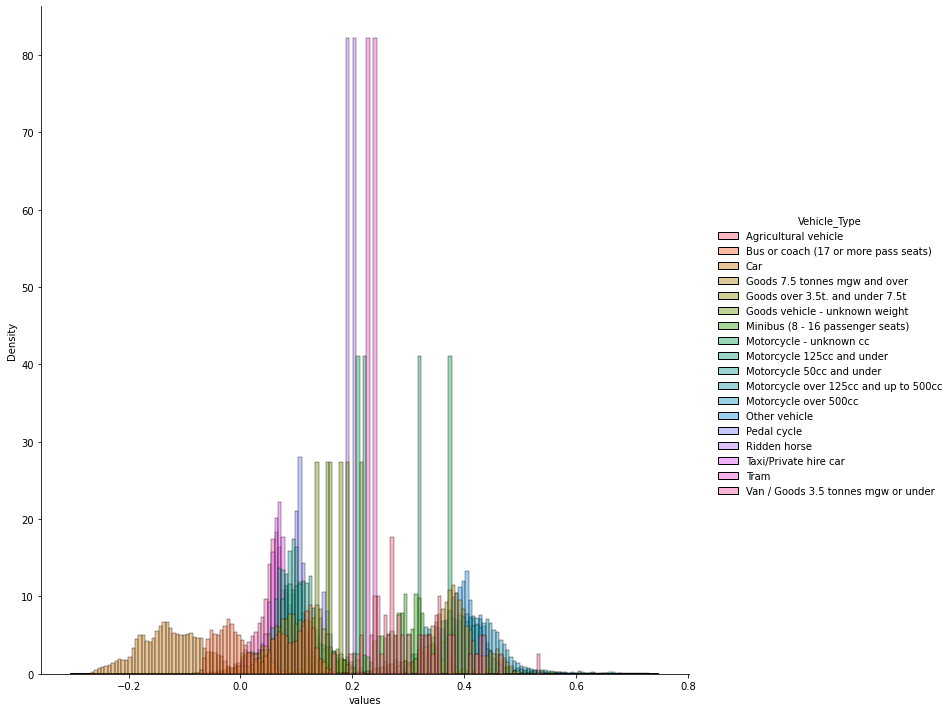

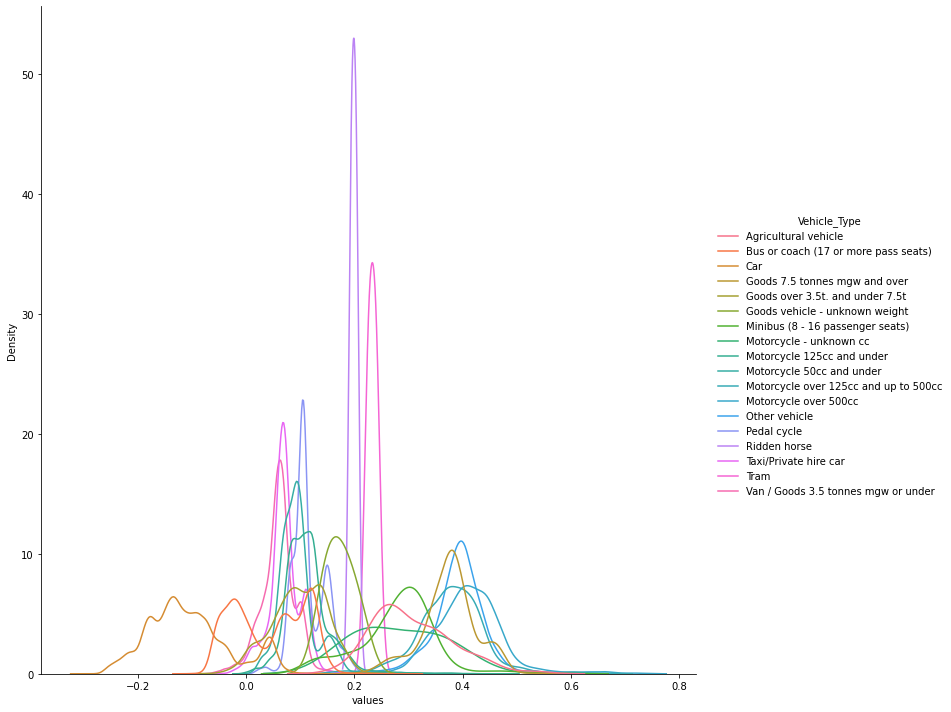

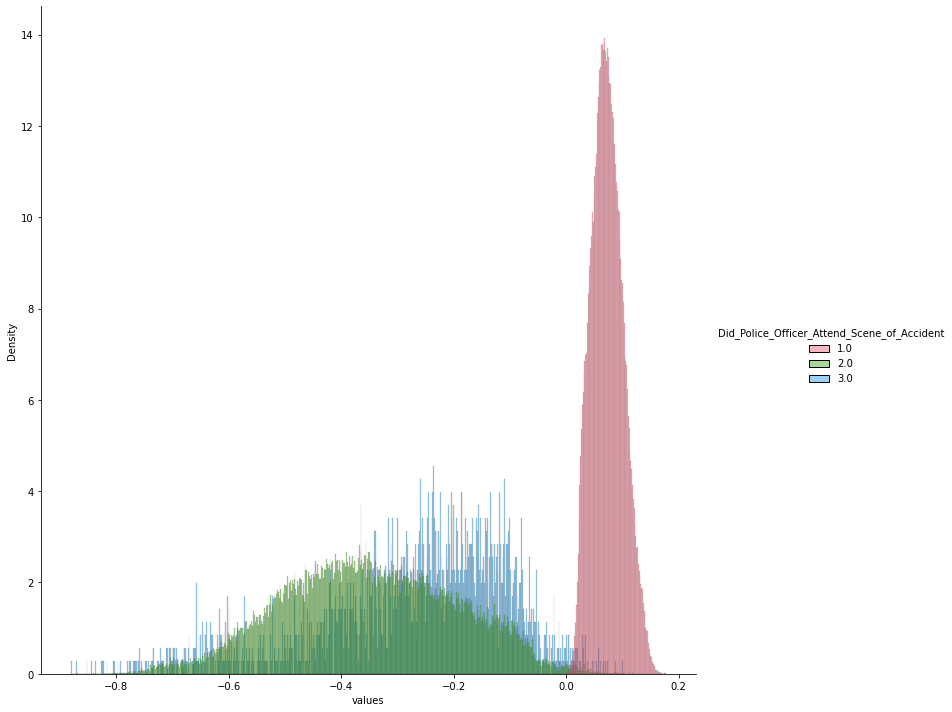

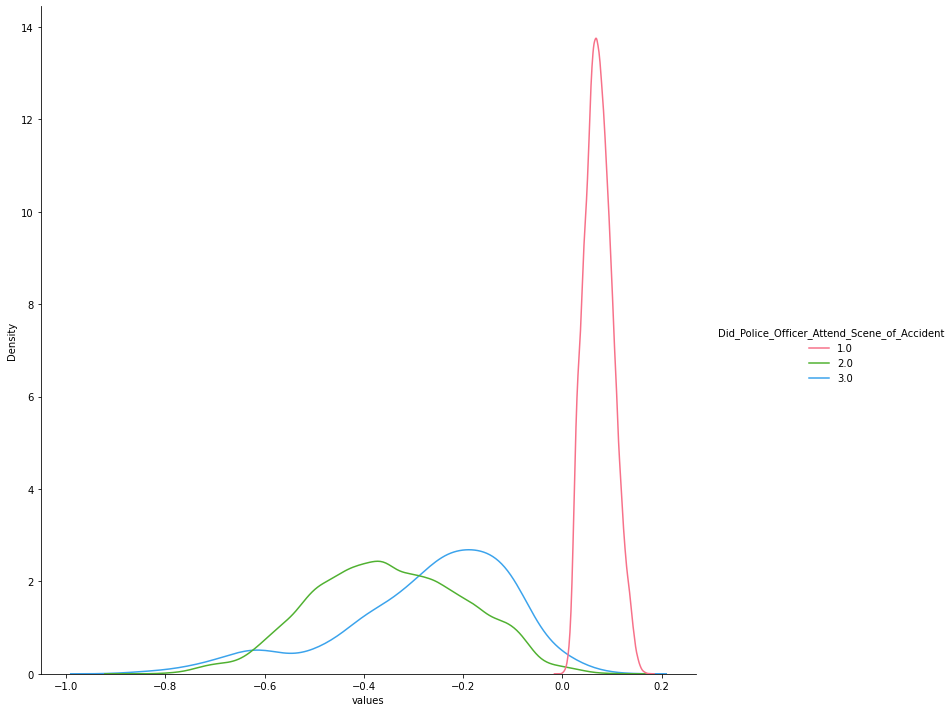

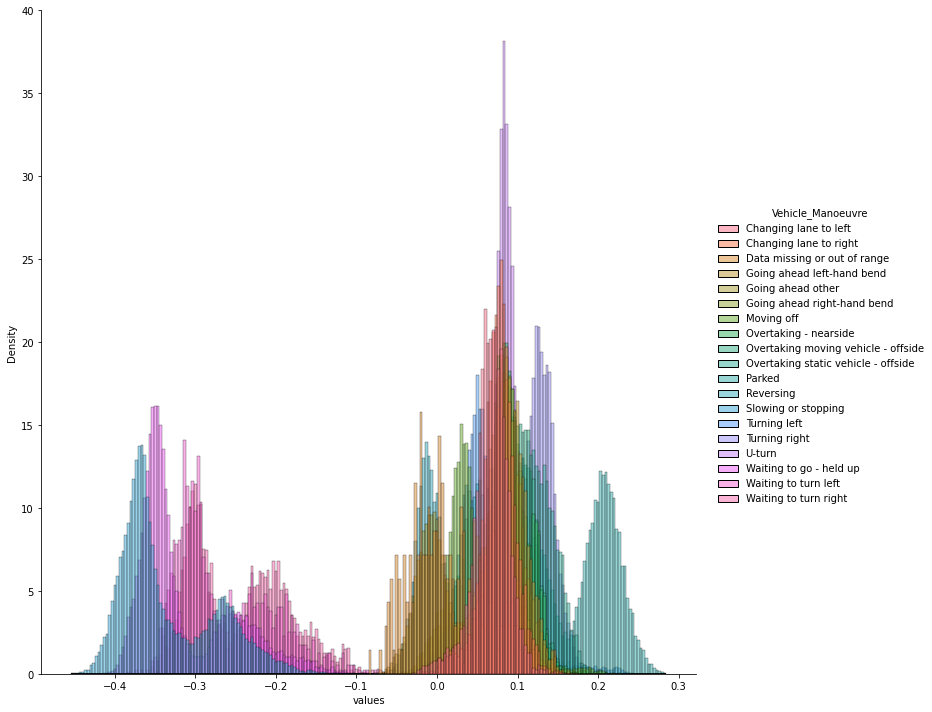

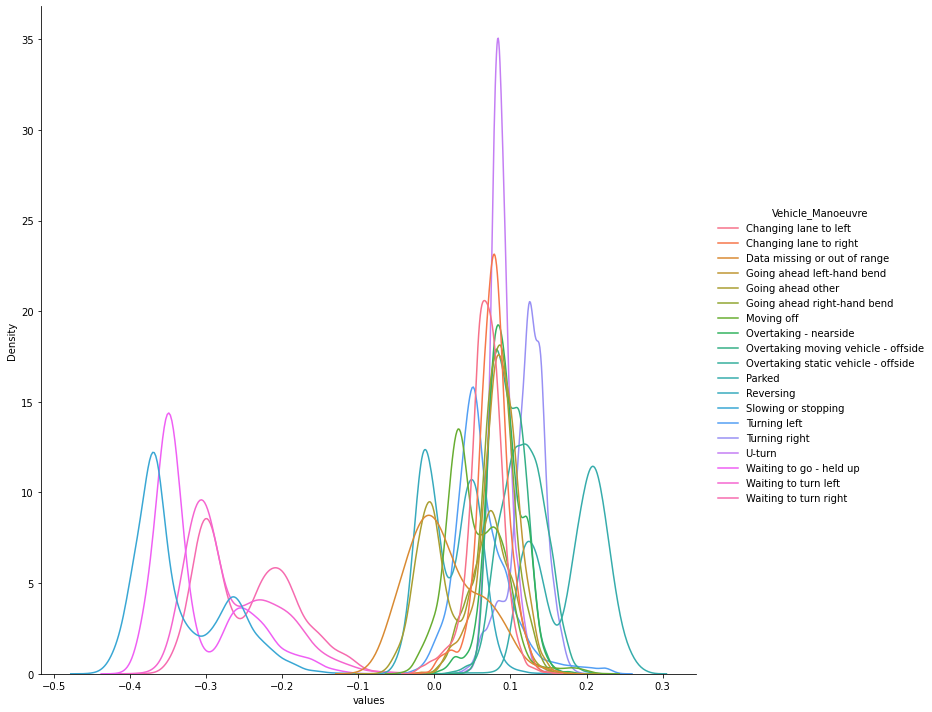

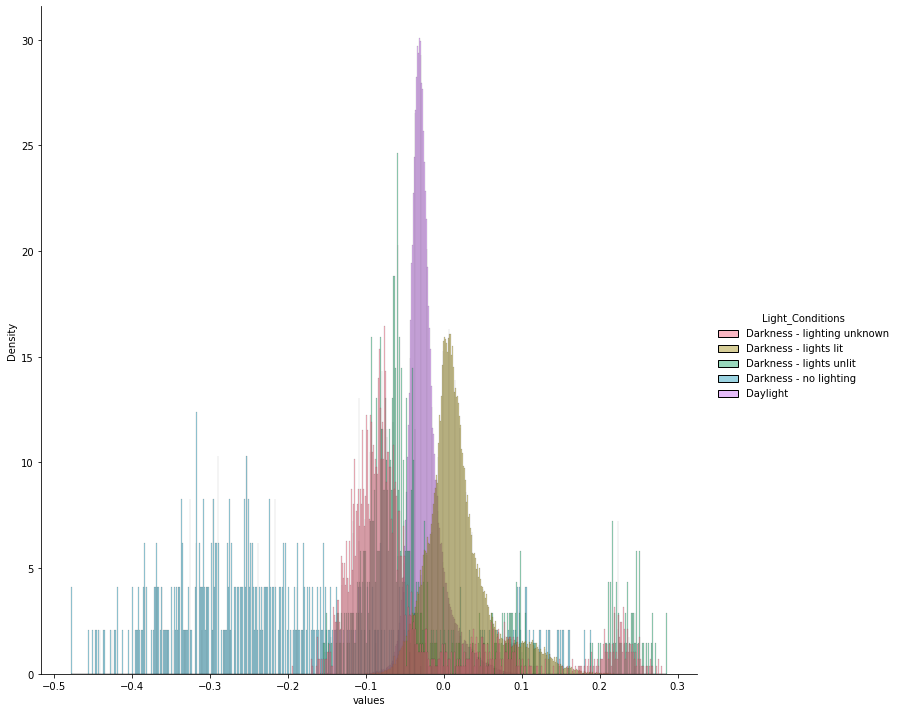

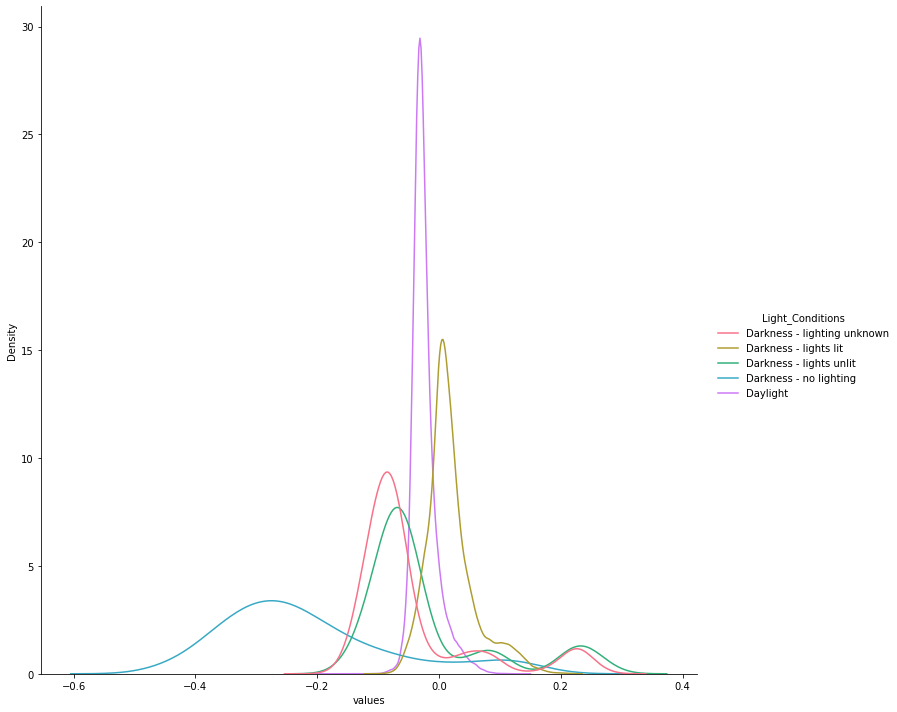

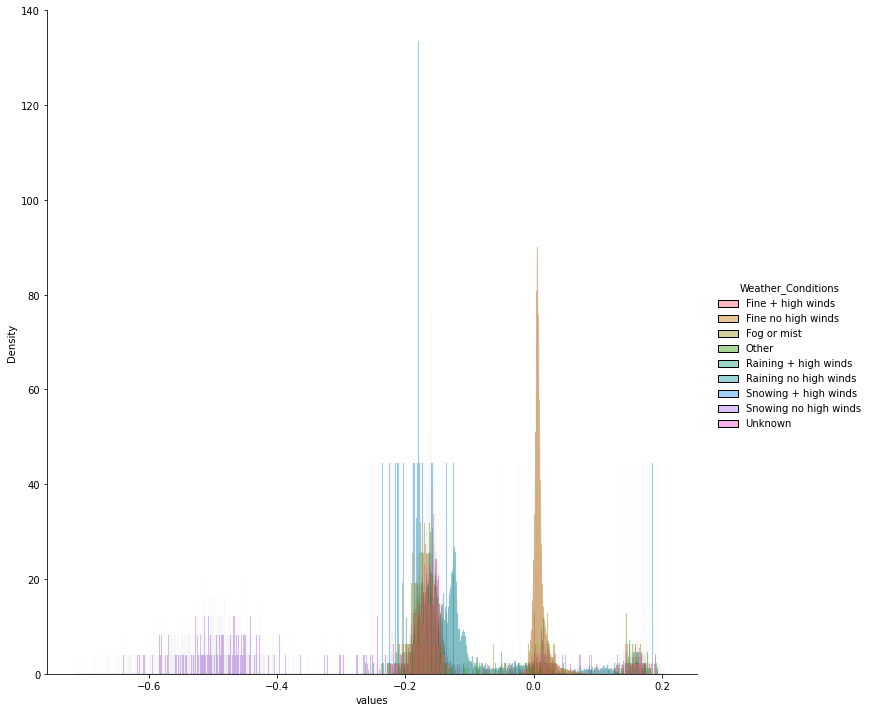

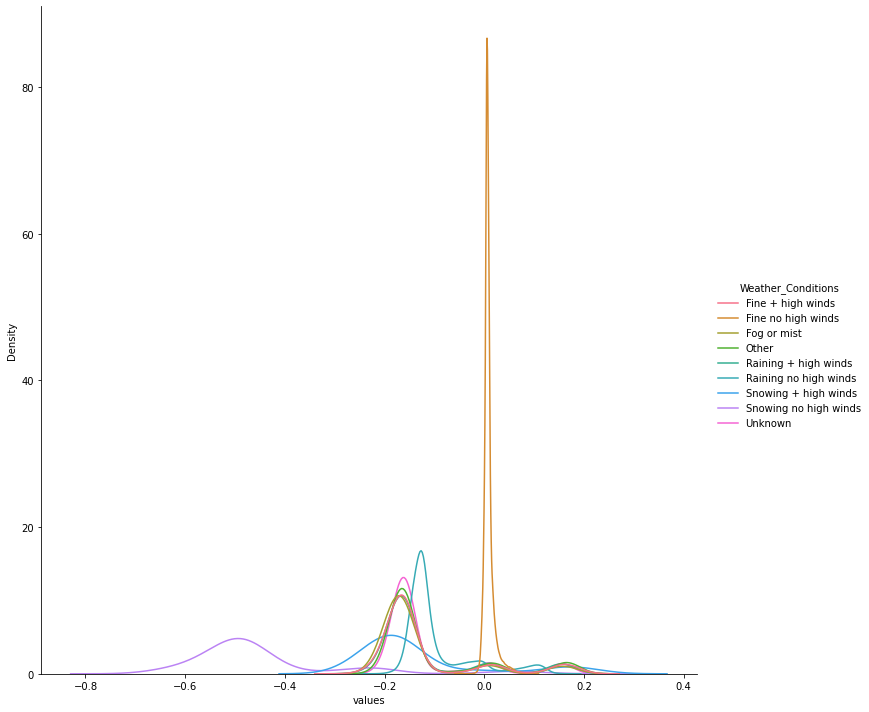

In [31]:
for feature in feature_columns:
    data = create_category_shap_value_dataframe(feature)
    density_plot = sns.displot(data=data,x="values",hue=feature, stat="density", common_norm=False, height=10,fill=True, palette=sns.color_palette("husl",data[feature].nunique()))
    density_kde = sns.displot(data=data,x="values",hue=feature, kind="kde", common_norm=False, height=10,palette=sns.color_palette("husl",data[feature].nunique()))
    density_plot.savefig("./plots/density_plot_"+feature+".jpg",bbox_inches="tight")
    density_kde.savefig("./plots/density_kde_"+feature+".jpg",bbox_inches="tight")

# Stats
lets calculate the mean, median for values in each category

In [32]:
for feature in feature_columns:
    shap_values_category = copy.deepcopy(shap_values_E)
    shap_values_category , new_shap_values_category_raw, unique_categorical_values= transform_shap_values_for_category(shap_values_category,X,feature)
    df_sh_raw = pd.DataFrame(new_shap_values_category_raw)
    # calculate standard statistics for each category
    df_stats = df_sh_raw.transpose().describe()
    df_stats = pd.DataFrame(dict(category = unique_categorical_values,
                            median = df_stats.loc['50%',:],
                            mean = df_stats.loc['mean',:],
                            count = df_stats.loc['count',:],
                            std = df_stats.loc['std',:],
                            p25 = df_stats.loc['25%',:],
                            p75 = df_stats.loc['75%',:],
                            min = df_stats.loc['min',:],
                            max = df_stats.loc['max',:],))
    with open('./data/'+feature+'_stats.pkl', 'wb') as b:
        pickle.dump(df_stats,b)

Lets do that also for the LSOA_of_Accident_Location

In [33]:
shap_values_category = copy.deepcopy(shap_values_E)
shap_values_category , new_shap_values_category_raw, unique_categorical_values= transform_shap_values_for_category(shap_values_category,X,'LSOA_of_Accident_Location')
df_sh_raw = pd.DataFrame(new_shap_values_category_raw)
df_stats = df_sh_raw.transpose().describe()
LSOA_stats = pd.DataFrame(dict(LSOA = unique_categorical_values,
                        median = df_stats.loc['50%',:],
                        mean = df_stats.loc['mean',:],
                        count = df_stats.loc['count',:],
                        std = df_stats.loc['std',:],
                        p25 = df_stats.loc['25%',:],
                        p75 = df_stats.loc['75%',:],
                        min = df_stats.loc['min',:],
                        max = df_stats.loc['max',:],))

LSOA_stats['impact'] = np.where( LSOA_stats['median'] >= 0, 1, 0) 
LSOA_stats

,LSOA,median,mean,count,std,p25,p75,min,max,impact
0,E01001689,-0.208143,-0.108839,56.0,0.249935,-0.238987,-0.084531,-0.338633,0.732093,0
1,E01002011,-0.056827,0.047123,151.0,0.313697,-0.170445,0.144705,-0.319638,1.113375,0
2,E01004344,-0.105432,-0.027866,251.0,0.252866,-0.163725,0.020525,-0.358859,1.048780,0
3,E01003263,-0.120297,0.023746,68.0,0.371786,-0.228595,0.215092,-0.349130,1.087461,0
4,E01000433,-0.137795,-0.025408,41.0,0.371103,-0.315720,0.159233,-0.441234,0.816692,0
...,...,...,...,...,...,...,...,...,...,...
4952,E01004587,-0.365760,-0.365760,2.0,0.081297,-0.394503,-0.337017,-0.423246,-0.308274,0
4953,E01000584,-0.322117,-0.322117,1.0,NaN,-0.322117,-0.322117,-0.322117,-0.322117,0
4954,E01003629,-0.392666,-0.392666,1.0,NaN,-0.392666,-0.392666,-0.392666,-0.392666,0
4955,E01001585,-0.382158,-0.382158,1.0,NaN,-0.382158,-0.382158,-0.382158,-0.382158,0


Lets also calculate the median of all LSOAs in on borough.

In [34]:
world = geopandas.read_file('./data/infuse_lsoa_lyr_2011.shp')
london_LSOA_geo = world[world.geo_code.isin(LSOA_stats.LSOA)]
london_LSOA_geo.head()

,geo_code,geo_label,geo_labelw,label,name,geometry
0,E01003513,Newham 035D,None,E92000001E09000025E01003513,Newham 035D,"POLYGON ((541893.189 181249.621, 541900.568 18..."
3,E01001159,Croydon 002C,None,E92000001E09000008E01001159,Croydon 002C,"POLYGON ((532233.977 170474.976, 532229.824 17..."
7,E01002714,Islington 017D,None,E92000001E09000019E01002714,Islington 017D,"POLYGON ((530778.966 184215.275, 530780.181 18..."
8,E01002061,Haringey 036A,None,E92000001E09000014E01002061,Haringey 036A,"POLYGON ((531269.550 188183.770, 531269.914 18..."
11,E01000696,Bromley 007E,None,E92000001E09000006E01000696,Bromley 007E,"POLYGON ((544100.850 170609.733, 544142.301 17..."


In [35]:
LSOA_geo = london_LSOA_geo.loc[:,['geo_code','geo_label']]
LSOA_geo.columns = ['LSOA','geo_label']
LSOA_stats_borough = pd.merge(LSOA_stats,LSOA_geo, on='LSOA', how='left')
LSOA_stats_borough['borough'] = LSOA_stats_borough['geo_label'].str.split(' 0',expand=True)[0]
LSOA_stats_borough

,LSOA,median,mean,count,std,p25,p75,min,max,impact,geo_label,borough
0,E01001689,-0.208143,-0.108839,56.0,0.249935,-0.238987,-0.084531,-0.338633,0.732093,0,NaN,NaN
1,E01002011,-0.056827,0.047123,151.0,0.313697,-0.170445,0.144705,-0.319638,1.113375,0,Haringey 030D,Haringey
2,E01004344,-0.105432,-0.027866,251.0,0.252866,-0.163725,0.020525,-0.358859,1.048780,0,Waltham Forest 008B,Waltham Forest
3,E01003263,-0.120297,0.023746,68.0,0.371786,-0.228595,0.215092,-0.349130,1.087461,0,Lewisham 023A,Lewisham
4,E01000433,-0.137795,-0.025408,41.0,0.371103,-0.315720,0.159233,-0.441234,0.816692,0,Bexley 008F,Bexley
...,...,...,...,...,...,...,...,...,...,...,...,...
4952,E01004587,-0.365760,-0.365760,2.0,0.081297,-0.394503,-0.337017,-0.423246,-0.308274,0,Wandsworth 009D,Wandsworth
4953,E01000584,-0.322117,-0.322117,1.0,NaN,-0.322117,-0.322117,-0.322117,-0.322117,0,Brent 033E,Brent
4954,E01003629,-0.392666,-0.392666,1.0,NaN,-0.392666,-0.392666,-0.392666,-0.392666,0,Newham 015E,Newham
4955,E01001585,-0.382158,-0.382158,1.0,NaN,-0.382158,-0.382158,-0.382158,-0.382158,0,Greenwich 016B,Greenwich


Some LSOA apparently have a high median contribution to the prediction. We see that in the kind of long tale at the right.
We can use that information for plotting it next on a map

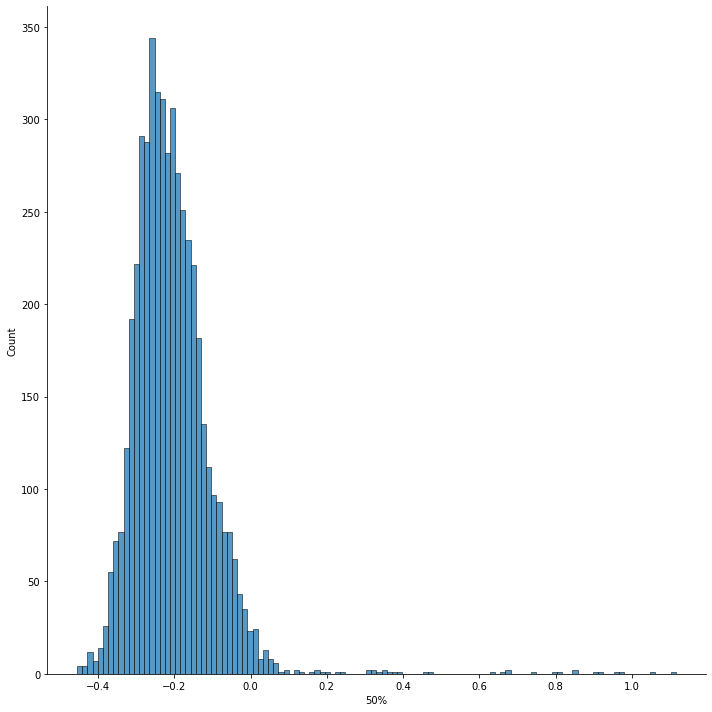

In [36]:
import seaborn as sns
sns.displot(df_stats.loc['50%',:], height=10)

In [37]:
with open('./data/LSOA_stats.pkl', 'wb') as b:
    pickle.dump(LSOA_stats_borough,b)